In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from src.functions import *
from sklearn.cluster import KMeans

In [2]:
norm_ion_intensities = pd.read_pickle('data/Mx_Co_Cultured/normalized_ion_intensities.pkl')
norm_cor_ion_intensities = pd.read_pickle('data/Mx_Co_Cultured/normalized_corrected_ion_intensities.pkl')
norm_ion_intensities


,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


HeLa      715
NIH3T3    492
Name: celltype, dtype: int64


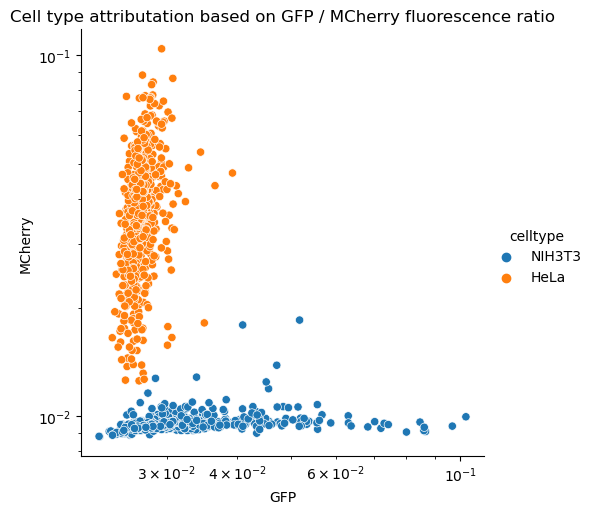

In [3]:
condition_metadata = pd.read_csv('data/Mx_Co_Cultured/MORPHnMOL.csv')
condition_metadata['GFP'] = condition_metadata.Intensity_MeanIntensity_GFP_quantif
condition_metadata['MCherry'] = condition_metadata.Intensity_MeanIntensity_mCherry_quantif
condition_metadata['fluorescence_ratio'] = np.log(condition_metadata.GFP / condition_metadata.MCherry)

#condition_metadata['celltype'] = 'HeLa' if condition_metadata.fluorescence_ratio < 0.8 else 'NIH3T3'
condition_metadata['celltype'] = np.where(condition_metadata.fluorescence_ratio < 0.8, 'HeLa', 'NIH3T3')

print(condition_metadata['celltype'].value_counts())

plot = sns.relplot(data=condition_metadata, x='GFP', y='MCherry', hue='celltype')
plot.set(xscale='log')
plot.set(yscale='log')
plot.set(title='Cell type attributation based on GFP / MCherry fluorescence ratio')

In [4]:
condition_metadata = condition_metadata[['ObjectNumber', 'celltype', 'GFP', 'MCherry', 'fluorescence_ratio']]
condition_metadata.index = [CELL_PRE + str(i) for i in condition_metadata.ObjectNumber]
# condition_metadata.index = condition_metadata.index.map(str)
# norm_ion_intensities.index = norm_ion_intensities.index.map(str)

condition_metadata.index

Index(['cell_11', 'cell_13', 'cell_14', 'cell_15', 'cell_16', 'cell_17',
       'cell_19', 'cell_20', 'cell_21', 'cell_22',
       ...
       'cell_1482', 'cell_1487', 'cell_1489', 'cell_1491', 'cell_1494',
       'cell_1500', 'cell_1503', 'cell_1510', 'cell_1512', 'cell_1528'],
      dtype='object', length=1207)

In [63]:
included_cells = norm_ion_intensities.index.intersection(condition_metadata.index)
adata = ad.AnnData(X=norm_ion_intensities.loc[included_cells], obs=condition_metadata.loc[included_cells])
adata_cor = ad.AnnData(X=norm_cor_ion_intensities.loc[included_cells], obs=condition_metadata.loc[included_cells])


/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
def preprocess(adata):
    sc.pp.filter_cells(adata, min_genes=5)
    #sc.pp.log1p(adata)
    sc.pp.scale(adata)

preprocess(adata)
preprocess(adata_cor)

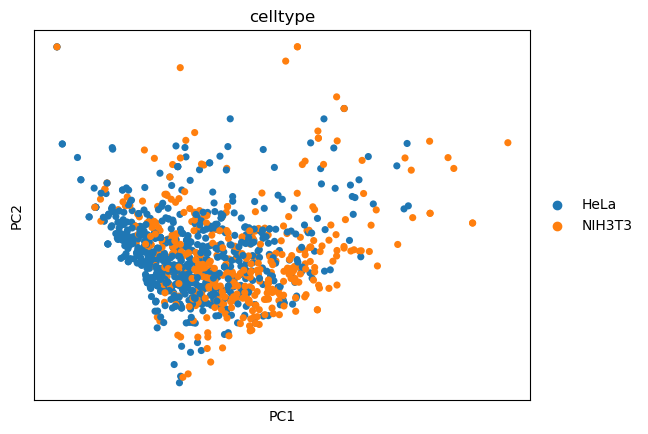

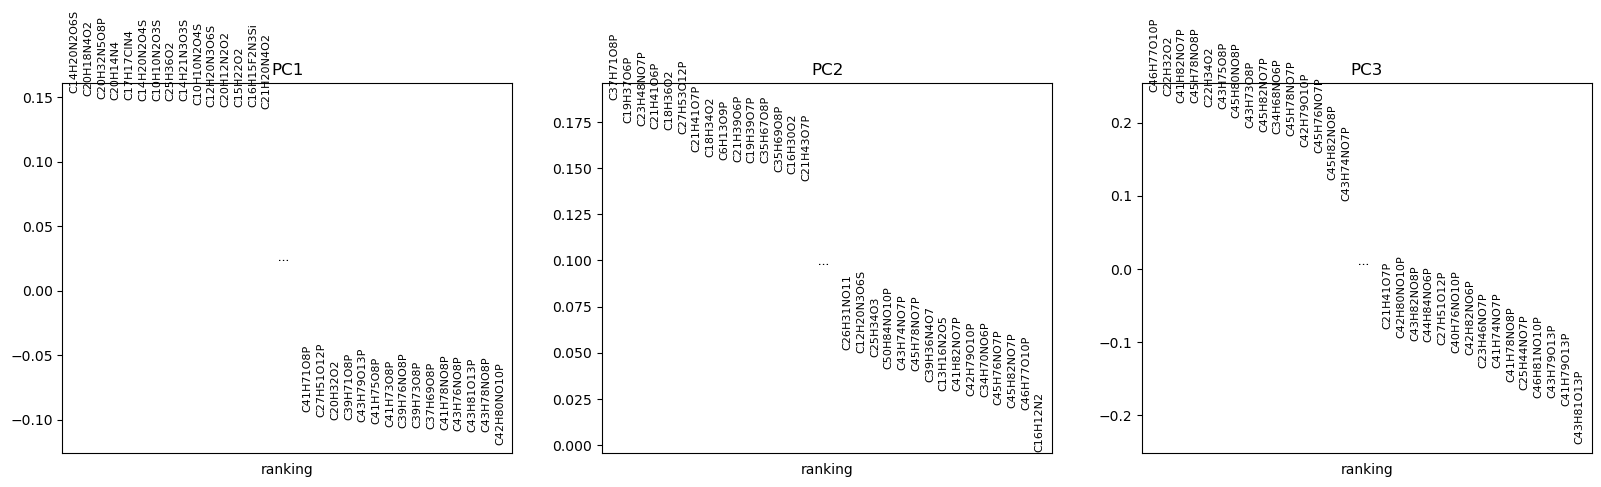

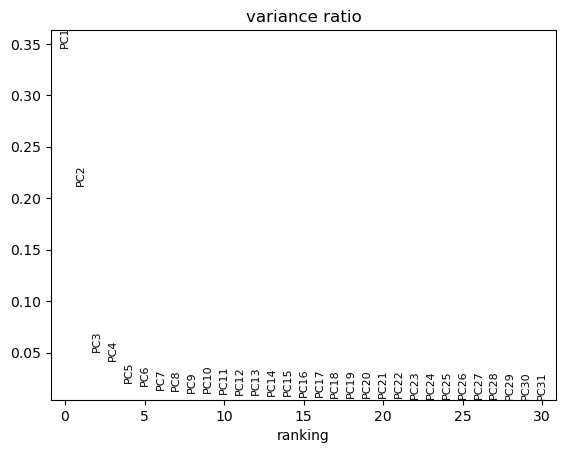

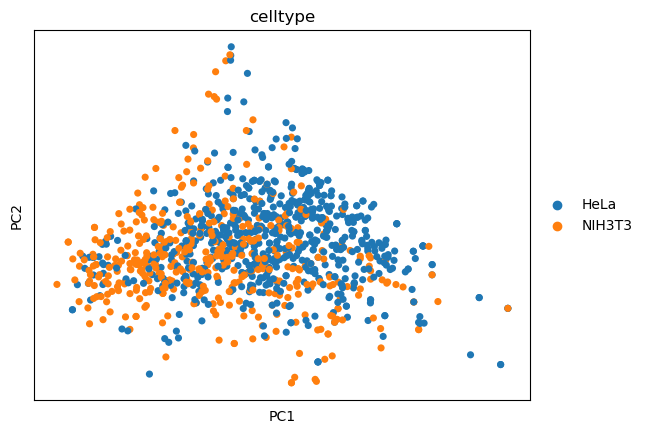

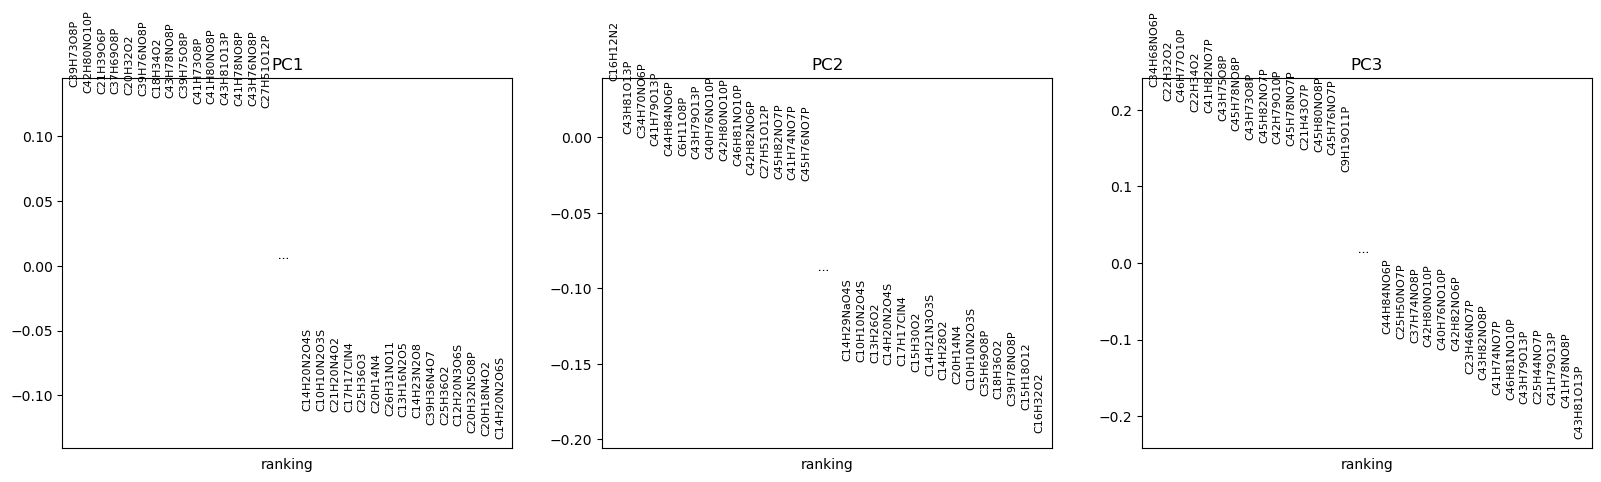

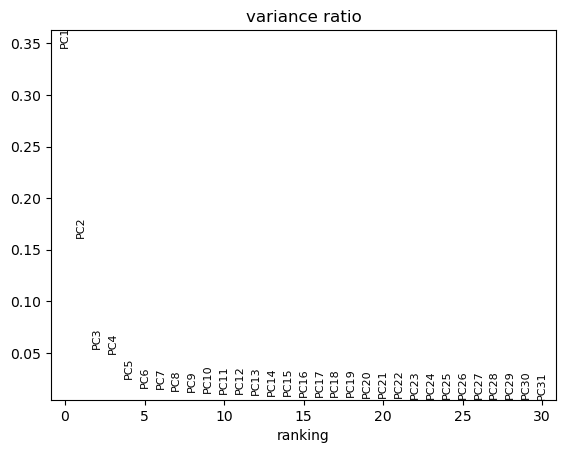

In [65]:
def dimred_pca(adata):
    sc.pp.pca(adata)
    sc.pl.pca_overview(adata, color='celltype')

dimred_pca(adata)
dimred_pca(adata_cor)

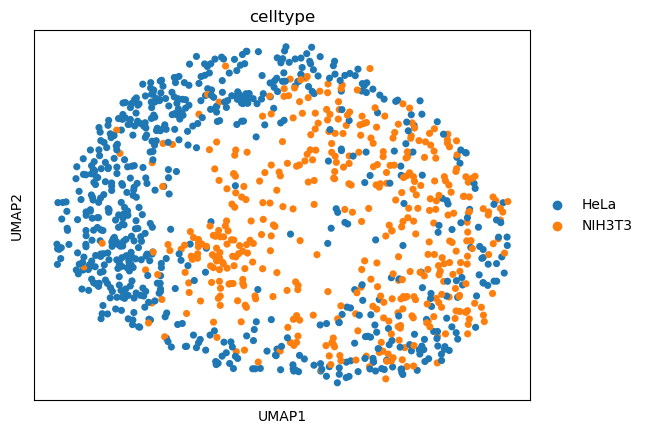

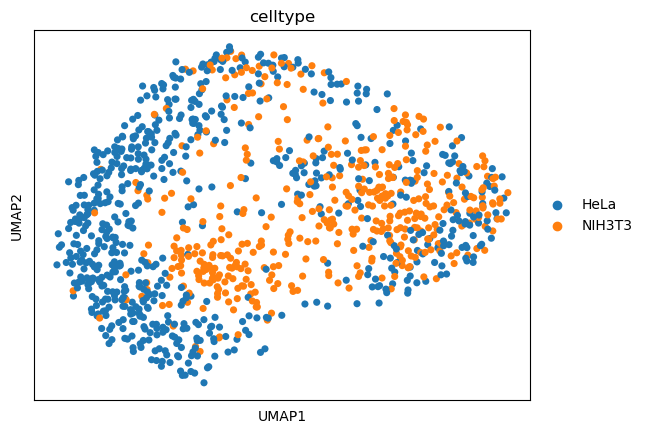

In [66]:
def dimred_umap(adata):
    sc.pp.neighbors(adata, n_neighbors=200, metric='cosine')
    sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=1, n_components=2)
    sc.pl.umap(adata, color='celltype')

dimred_umap(adata)
dimred_umap(adata_cor)

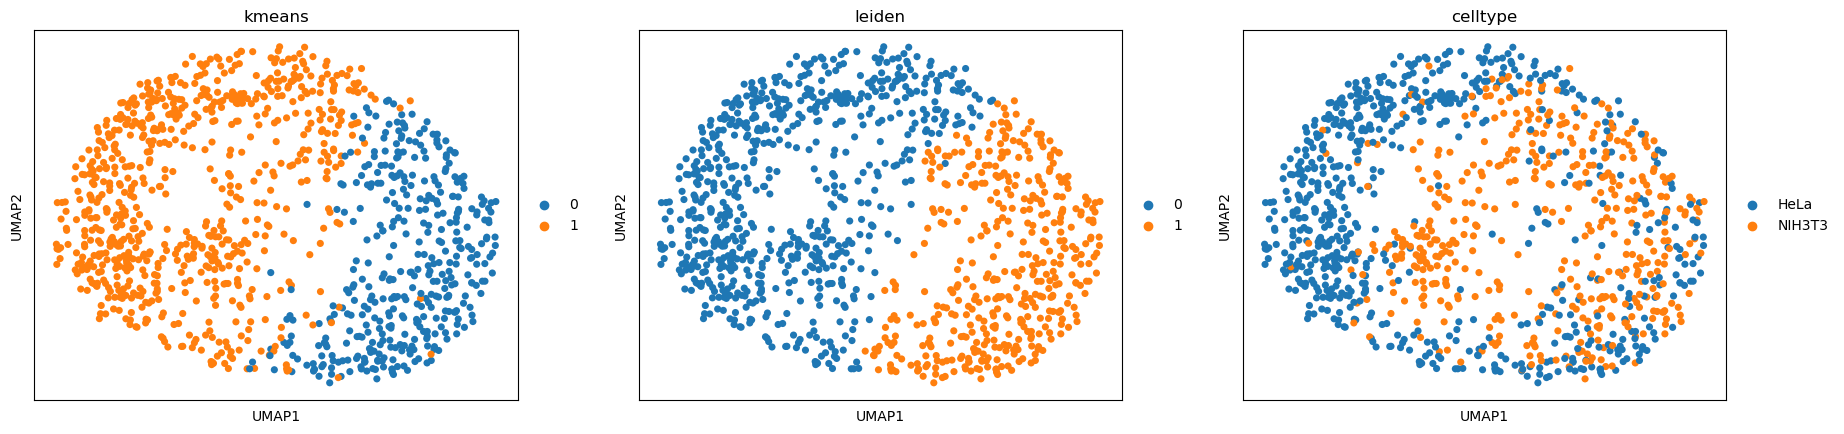

Leiden acccuracy score: 0.6667
KMeans completeness score: 0.0728


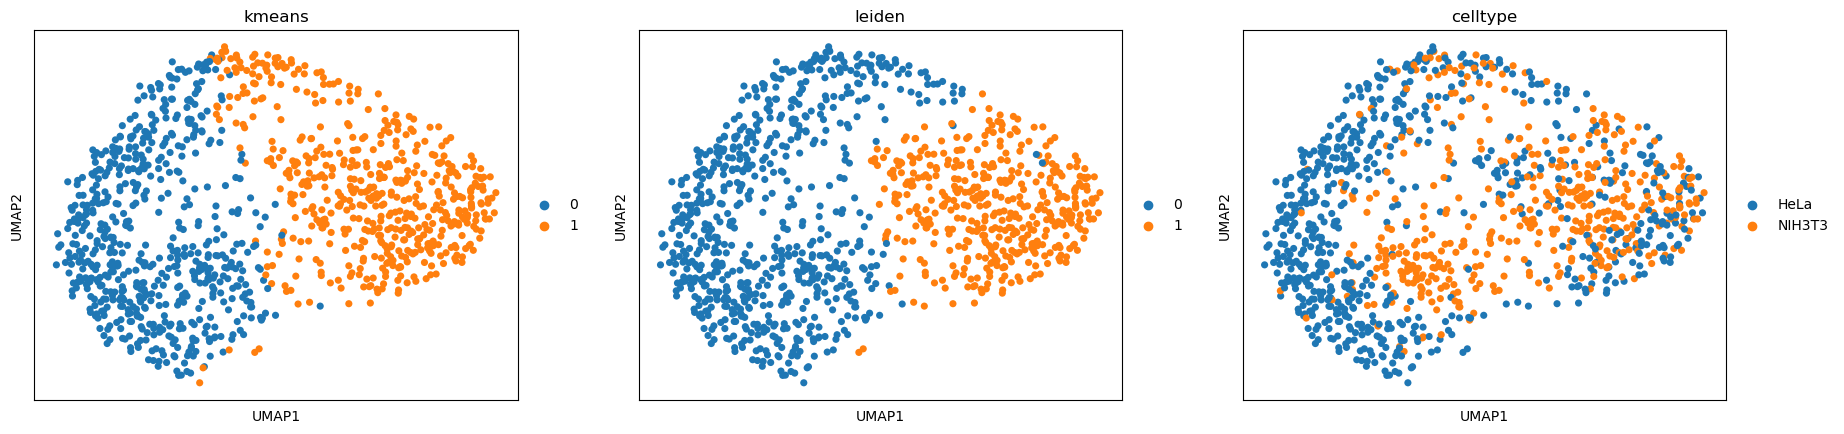

Leiden acccuracy score: 0.6737
KMeans completeness score: 0.0731


In [67]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import accuracy_score

def kmeans_clust(adata):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = kmeans.labels_.astype(str)

    sc.tl.leiden(adata, resolution=0.2)

    sc.pl.umap(adata, color=['kmeans', 'leiden', 'celltype'])
    print('Leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'].replace(['HeLa', 'NIH3T3'], ['0', '1']), y_pred = adata.obs['leiden']))
    print('KMeans completeness score: %1.4f' % completeness_score(adata.obs['celltype'], adata.obs['kmeans']))

kmeans_clust(adata)
kmeans_clust(adata_cor)


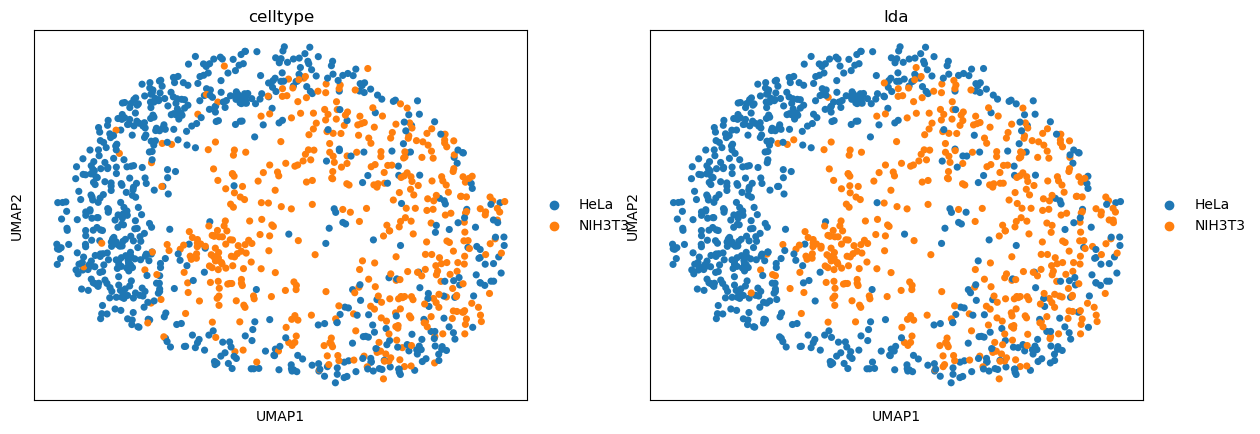

LDA accuracy after 10-fold cross-validation: 0.9156 (±0.0214)


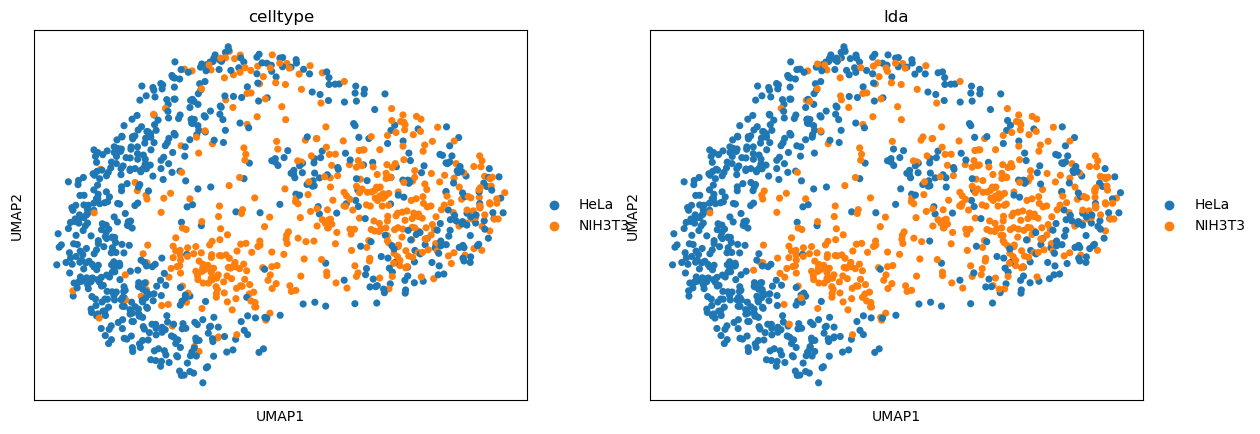

LDA accuracy after 10-fold cross-validation: 0.9060 (±0.0251)


In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def LDA(adata):
    predictors = adata.X
    result = adata.obs['celltype']
    model = LinearDiscriminantAnalysis()
    model.fit(predictors, result)  

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, predictors, result, scoring='accuracy', cv=cv, n_jobs=10)
    
    adata.obs['lda'] = model.predict(adata.X)
    sc.pl.umap(adata, color=['celltype', 'lda'])
    print("LDA accuracy after 10-fold cross-validation: %1.4f (±%1.4f)" % (np.mean(scores), np.std(scores)))  


LDA(adata) 
LDA(adata_cor) 